Паблик: https://vk.com/public81208883, id:-81208883


Корпус всех постов и комментариев:


Корпус всех лемматизированных постов и комментариев:


Sql база данных:

В данной работе я:
- Оформила программу по PEP8(Кроме W391, W605, E722, E402 из-за особенностей jupyter).
- Скачала абсолютно все посты и комментарии из группы.
- Посчитала среднюю длину постов и комментариев в словах и построила соответствующие графики.
- Программа умеет доставать из профиля пользователя параметры пол, город и возраст, а для постов подробную дату публикации.
- Раскрасила и подписала все графики.
- Построила графики зависимости средней длины комментариев от города и возраста.
- Построила графики зависимости средней длины поста от года и месяца публикации.
- Построила график частотности для топ-30 слов по нелемматизированным текстам.
- Построила график частотности для топ-30 слов по лемматизированным текстам.
- Построила облако слов для топ-30 слов по лемматизированным текстам.
- Записала корпус постов и комментариев в текстовый файл.
- Записала корпус лемматизированных постов и комментариев в текстовый файл. 
- Записала всю собранную информацию о пользователях, постах и комментариях в sql базу данных.
- Оптимизировала работу программы с 15 минут до 1,5 минут.

# Подготовка

По какой-то причине даже 64-битный python возвращает win32. Из-за этого не может работать pymystem3. Поэтому приходится обманывать систему, самим присваивая её разрядность. Но на правильно установленном python pymystem3 запускается.

In [1]:
# Библиотеки
import vk_api
import re
from datetime import date
import time

# Графики
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython import display

# Обман системы для pymystem3
import sys
sys.platform = "win64"
from pymystem3 import Mystem

# Облако
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# База данных
import sqlite3

# Данные
Укажите сервисный ключ доступа в файле config.txt

Для Plotly Вы можете создать собственный аккаунт на https://plot.ly/python/

In [2]:
# Чтение данных из файла конфигураций
with open('config.txt', 'r', encoding='utf-8') as f:
    text = f.read().split('\n')
    try:
        APP_TOKEN = text[0].split(" = ")[1]
        VERSION = text[1].split(" = ")[1]
        GROUP_ID = int(text[2].split(" = ")[1])
        PLOTLY_USER = text[3].split(" = ")[1]
        PLOTLY_KEY = text[4].split(" = ")[1]
        print("Успешное чтение конфигураций")
    except:
        raise ErrorFile("Ошибка в файле конфигураций")

# Авторизация в plotly
plotly.tools.set_credentials_file(PLOTLY_USER,
                                  PLOTLY_KEY)

Успешное чтение конфигураций


# Функции

Для вывода прогресса был взят открытый код функции log_progress из гитхаба
https://github.com/kuk/log-progress

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

Функция для очистки текста от смайликов, странных символов и конструкций вида [id00000000|name]

In [4]:
def vk_clean(text):
    new_text = ""
    i = 0
    while(i < len(text)):
        try:
            if text[i] == '[':
                while(text[i] != '|'):
                    i += 1
                f = i
                while(text[i] != ']'):
                    i += 1
                g = i
                new_text += text[f + 1:g]
            else:
                try:
                    new_text += re.findall('[\w ,.!?"-]', text[i])[0]
                except:
                    pass
        except:
            try:
                new_text += re.findall('[\w\s,.!?"-]', text[i])[0]
            except:
                pass
        i += 1
    return new_text

Функция для подсчёта количества слов в тексте.

In [5]:
def words_len(text):
    text = text.replace("\n", " ")
    text = text.replace(",", "").replace(".", "").replace("?", "")
    text = text.replace("!", "").replace("–", "")
    words = text.split()
    return len(words)

Функция, возвращающая массив слов из текста

In [6]:
def get_word(text):
    text = text.lower()
    text = text.replace("\n", " ").replace("-", " ")
    text = text.replace(",", "").replace(".", "").replace("?", "")
    text = text.replace("!", "").replace("–", "")
    words = text.split()
    return words

Функция для вычисления возраста. Если возраст не содержит корректного поля вида 00.00.0000, возвращаем 0

In [7]:
def calculate_age(i):
    if not i:
        i = ''
    today = date.today()
    i = i.split('.')
    if len(i) < 3:
        return 0
    else:
        day = int(i[0])
        month = int(i[1])
        year = int(i[2])
    return today.year - year - ((today.month, today.day) < (month, day))

# Работа с VK

Авторизация

In [8]:
from vk_api import vk_api
vk_session = vk_api.VkApi(token=APP_TOKEN)
vk = vk_session.get_api()

Скачиваем все посты.

Узнаём, сколько постов в группе, и скачиваем по 100. Важную информацию из поста храним в словаре.

In [9]:
posts = []
# Пустой запрос, чтобы узнать общее количество постов в группе
response = vk.wall.get(owner_id=GROUP_ID, count=0, offset=0)
count = response["count"]
counter = 0
# ВК выдает по 100 постов
while (counter < count):
    # Скачиваем по 100 постов
    response = vk.wall.get(owner_id=GROUP_ID, count=100, offset=counter)
    for item in response["items"]:
        posts.append({"id": item["id"], "text": item["text"], "comments": [],
                      "from_id": item["from_id"], "date": item["date"]})
    counter += 100
print("Постов скачано: " + str(len(posts)))

Постов скачано: 125


Скачиваем комментарии для каждого поста.

Узнаём количество и скачиваем по 100 штук. Бывают удалённые комментарии. Информацию о комментариях добавляем в информацию о посте.

In [10]:
comment_counter = 0
bad_counter = 0
for post in log_progress(posts, every=1):
    # Пустой запрос, чтобы узнать общее количество комментариев к посту
    response = vk.wall.getComments(owner_id=GROUP_ID,
                                   post_id=post["id"],
                                   count=0,
                                   offset=0)
    count = response["count"]
    counter = 0
    while (counter < count):
        response = vk.wall.getComments(owner_id=GROUP_ID,
                                       post_id=post["id"],
                                       count=100,
                                       offset=counter)
        for item in response["items"]:
            comment_counter += 1
            try:
                if not item.get("deleted"):  # Если комментарий можно прочитать
                    post["comments"].append({"id": item["id"],
                                             "from_id": item["from_id"],
                                             "text": item["text"]})
                else:
                    print(("Невозможно обработать комментарий," +
                           "потому что он удалён:\n") + str(item) + "\n")
                    bad_counter += 1
            except:
                print("Except:\n" + str(item) + "\n")
                bad_counter += 1

            counter += 100

print("Постов обработано: " + str(comment_counter))

Невозможно обработать комментарий,потому что он удалён:
{'id': 5374, 'parents_stack': [], 'date': 1553298342, 'thread': {'count': 2, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}, 'deleted': True}

Постов обработано: 3545


Тест на количество комментариев.

Используя информацию о том, сколько комментариев мы не смогли прочитать, смотрим, все ли комментарии мы занесли в массив.

In [11]:
test_counter = 0
for post in log_progress(posts, every=1):
    test_counter += len(post["comments"])
print("Скачено постов: " + str(comment_counter))
print("Испорченых постов: " + str(bad_counter))
print("Постов в базе: " + str(test_counter))
if(test_counter == comment_counter - bad_counter):
    print("Все посты занесены верно")
else:
    print("Ошибка в занесении постов")

Скачено постов: 3545
Испорченых постов: 1
Постов в базе: 3544
Все посты занесены верно


Очищаем тексты постов и комментариев от смайликов, мусора и заменяем обращения вида [id|Имя]. Полученный текст снова записываем в информацию о посте

In [12]:
for post in posts:
    post['clean_text'] = vk_clean(post["text"])
    for comment in post["comments"]:
        comment['clean_text'] = vk_clean(comment["text"])

Лемматизируем текст

Для этого объединяем все тексты постов и комментариев в один большой текст, разделяя их специальным ключом "DARYI ", который не будет изменён. А после собираем всё обратно.

In [13]:
m = Mystem()
text = ""
# Для каждого поста и комментариев, принадлежащих ему.
# Очень частая конструкция в этой работе.
# Cобираем всё в один текст
for post in posts:
    text += post['clean_text'] + "DARYI "
    for comment in post['comments']:
        text += comment['clean_text'] + "DARYI "
lemmas = m.lemmatize(text)
text = "".join(lemmas)
temp_mas = text.split("DARYI ")


i = 0
# Разбираем обратно в том же порядке
for post in posts:
    post['lem_text'] = temp_mas[i]
    i += 1
    for comment in post['comments']:
        comment['lem_text'] = temp_mas[i]
        i += 1

Заполняем файл 'clean_text.txt' текстом из постов и комментариев. 
Пустые тексты могут возникать, например, если пользователь прикрепил только картинку.

In [14]:
with open('clean_text.txt', 'w', encoding='utf-8') as f:
    for post in log_progress(posts, every=1):
        f.write("\n\nПост: " + post['clean_text'] + '\n')
        for comment in post["comments"]:
            if(len(comment['clean_text']) > 0):  # Без пустых комментариев
                f.write("Комментарий: " + comment['clean_text'] + '\n')
print("Файл заполнен")

Файл заполнен


Заполняем файл 'lem_text.txt' лемматизированными текстами

In [15]:
with open('lem_text.txt', 'w', encoding='utf-8') as f:
    for post in log_progress(posts, every=1):
        f.write("\n\nПост: " + post['lem_text'] + '\n')
        for comment in post["comments"]:
            if(len(comment['lem_text']) > 0):  # Без пустых комментариев
                f.write("Комментарий: " + comment['clean_text'] + '\n')
print("Файл заполнен")

Файл заполнен


Считаем длины постов, комментариев и среднюю длину комментариев для каждого поста. Все данные всё также храним в информации о посте.

In [16]:
for post in log_progress(posts, every=1):
    post['text_len'] = words_len(post['clean_text'])
    average_value = 0
    for comment in post['comments']:
        comment['text_len'] = words_len(comment['clean_text'])
        average_value += comment['text_len']
    post['average_value'] = round(average_value / len(post['comments']))
print("Посчитано")

Посчитано


Загружаем информацию о пользователях

Для каждого пользователя вк, автора поста или группы загружаем пол, город и дату рождения. Если их нет, то записываем в поле None. Для ускорения работы запрашиваем информацию о 500 пользователях за раз.

In [17]:
people = {}
# Для всех постов и комментариев запоминаем автора
for post in posts:
    if not people.get(post["from_id"]):
        people[post["from_id"]] = {"posts_id": [],
                                   "comments_id": []}
    people[post["from_id"]]["posts_id"].append(post["id"])
    for comment in post["comments"]:
        if not people.get(comment["from_id"]):
            people[comment["from_id"]] = {"posts_id": [],
                                          "comments_id": []}
        people[comment["from_id"]]["comments_id"].append(comment["id"])
# Собираем id в массив для запроса
user = []
for id in log_progress(people, every=10):
    if id > 0:  # Если это пользователь, а не группа
        user.append(id)
# Запрашиваем информацию по 500 пользователей
count = len(user)
counter = 0
while (counter < count):
    response = vk.users.get(user_ids=user[counter:counter + 500],
                            fields="sex, city, bdate")
    for item in response:
        try:
            people[item["id"]]["sex"] = item.get("sex")
            people[item["id"]]["city"] = item.get("city")
            people[item["id"]]["bdate"] = item.get('bdate')
        except:
            print(item)
    counter += 500
print("Информация о пользователях загружена")

Информация о пользователях загружена


# Работа с данными
Вычисляем возраст пользователей. Если его нет, то возраст равен 0.

In [18]:
for id in people:
    if id > 0:
        people[id]["age"] = calculate_age(people[id]["bdate"])

Считаем частотность употребления обычных слов. Убираем стоп-слова и вычисляем 30 самых частых.

In [19]:
# Считаем частоту употребления слов
len_words = {}
for post in posts:
    temp = get_word(post["clean_text"])
    for word in temp:
        # Проверка, есть ли слово в словаре
        if not len_words.get(word):
            len_words[word] = 1
        else:
            len_words[word] += 1
    for comment in post["comments"]:
        temp = get_word(comment["clean_text"])
        for word in temp:
            if not len_words.get(word):
                len_words[word] = 1
            else:
                len_words[word] += 1
# Сортируем слова по убыванию частоты их употребления
sorted_by_value = sorted(len_words.items(), key=lambda kv: kv[1]*(-1))
# Загружаем стоп-слова
file = open("rus_stopwords.txt", "r", encoding="utf-8")
stop_words = {}
for word in file.read().split('\n'):
    stop_words[word] = 1
clean_freq = []
# Отбираем 30 самых частых не стоп-слов
i = 0
for word in sorted_by_value:
    if not stop_words.get(word[0]):  # Если нет слов в словаре стоп-слов
        clean_freq.append(word)
        i += 1
    if i == 30:
        break

Считаем частотность появления лемматизированных слов. Убираем стоп-слова и вычисляем 30 самых частых.

In [20]:
# Считаем частоту употребления слов
len_words = {}
for post in posts:
    temp = get_word(post["lem_text"])
    for word in temp:
        # Проверка, есть ли слово в словаре
        if not len_words.get(word):
            len_words[word] = 1
        else:
            len_words[word] += 1
    for comment in post["comments"]:
        temp = get_word(comment["lem_text"])
        for word in temp:
            if not len_words.get(word):
                len_words[word] = 1
            else:
                len_words[word] += 1
# Сортируем слова по убыванию частоты их употребления
sorted_by_value = sorted(len_words.items(), key=lambda kv: kv[1]*(-1))
lem_freq = []
# Отбираем 30 самых частых не стоп-слов
i = 0
for word in sorted_by_value:
    if not stop_words.get(word[0]):
        lem_freq.append(word)
        i += 1
    if i == 30:
        break

Заполняем базу данных.

В ней три таблицы. С информацией о пользователях, о постах и о комментариях к постам.

In [21]:
# создаем базу данных
con = sqlite3.connect("mydatabase.db")

cur = con.cursor()
# Если в таблице были старые данные, удаляем
try:
    cur.execute('DROP TABLE ourposts')
    cur.execute('DROP TABLE ourcomments')
    cur.execute('DROP TABLE people')
except:
    pass

# Создаём таблицы
cur.execute('CREATE TABLE ourposts (' +
            'post_id integer, ' +
            'post_text text, ' +
            'from_id integer, ' +
            'len_post integer, ' +
            'average_com_len integer, ' +
            'clean_text text, ' +
            'lem_text_post text, ' +
            'post_date text)')

cur.execute('CREATE TABLE ourcomments (' +
            'com_id integer, ' +
            'post_id integer, ' +
            'com_text text, ' +
            'from_id integer, ' +
            'len_com integer, ' +
            'clean_text text, ' +
            'lem_text_com text)')

cur.execute('CREATE TABLE people (' +
            'id integer, ' +
            'sex text, ' +
            'city text, ' +
            'bdate text, ' +
            'posts_id text, ' +
            'comments_id text)')
con.commit()

# Создаём датасеты для заполнения
data_post = []
data_comments = []
for post in posts:
    data_post.append((post["id"],
                      post["text"],
                      post["from_id"],
                      post["text_len"],
                      post["average_value"],
                      post["clean_text"],
                      post["lem_text"],
                      post["date"]))

    for comment in post["comments"]:
        data_comments.append((comment["id"],
                              post["id"],
                              comment["text"],
                              comment["from_id"],
                              comment["text_len"],
                              comment["clean_text"],
                              comment["lem_text"]))
info = []
for id in people:
    if id > 0:
        posts_id = ''
        for i in people[id]["posts_id"]:
            posts_id += str(i) + ","
        comments_id = ''
        for i in people[id]["comments_id"]:
            comments_id += str(i) + ","
        info.append((id,
                     str(people[id]["sex"]),
                     (None if not people[id]["city"]
                      else people[id]["city"]["title"]),
                     str(people[id]["bdate"]),
                     posts_id,
                     comments_id))

# Заполняем
cur.executemany('INSERT INTO ourposts VALUES(?, ?, ?, ?, ?, ?, ?, ?)',
                data_post)

cur.executemany('INSERT INTO ourcomments VALUES(?, ?, ?, ?, ?, ?, ?)',
                data_comments)

cur.executemany('INSERT INTO people VALUES(?, ?, ?, ?, ?, ?)',
                info)
con.commit()

print('Данные записаны')
cur.close()
con.close()

Данные записаны


# Построение графиков

График зависимости средней длины комментариев от длины поста

Во всех графиках я делаю подписи особым шрифтом и меняю цвет столбцов.

In [22]:
x = []
y = []

# Для совпадающих значений по x вычисляем среднюю средних длин комментариев
post_lens = {}
for post in posts:
    post_len = post["text_len"]
    if not post_lens.get(post_len):
        post_lens[post_len] = [post["average_value"], 1]
    else:
        post_lens[post_len] = [post_lens[post_len][0] + post["average_value"],
                               post_lens[post_len][1] + 1]
for key in post_lens:
    post_lens[key] = round(post_lens[key][0] / post_lens[key][1])
# Заполняем данные для графика
for key in post_lens:
    x.append(key)
    y.append(post_lens[key])
# Cтроим график
data = [go.Bar(x=x, y=y)]
# Изменяем его внешний вид
layout = go.Layout(
    title=go.layout.Title(
        text='График зависимости средней длины комментариев от длины поста',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Длина поста',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Средняя длина комментариев',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
# Отображаем график
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='len_post_len_com')

c:\users\robot\appdata\local\programs\python\python37\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



График частотности для топ-30 слов по нелемматизированным текстам

In [23]:
x = []
y = []

for item in clean_freq:
    x.append(item[0])
    y.append(item[1])

data = [go.Bar(x=x, y=y, marker=dict(color='rgb(62,180,137)'))]
layout = go.Layout(
    title=go.layout.Title(
        text=('График частотности для топ-30 слов' +
              'по нелемматизированным текстам'),
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Слово',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Частотность',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='clear_top_30')

График частотности для топ-30 слов по лемматизированным текстам

In [24]:
x = []
y = []

for item in lem_freq:
    x.append(item[0])
    y.append(item[1])

data = [go.Bar(x=x, y=y, marker=dict(color='rgb(204,85,0)'))]
layout = go.Layout(
    title=go.layout.Title(
        text=('График частотности для топ-30' +
              'слов по лемматизированным текстам'),
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Слово',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Частотность',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='lem_top_30')

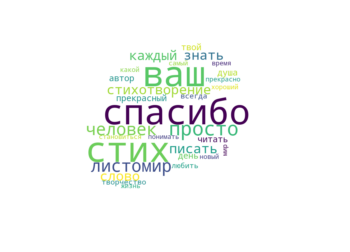

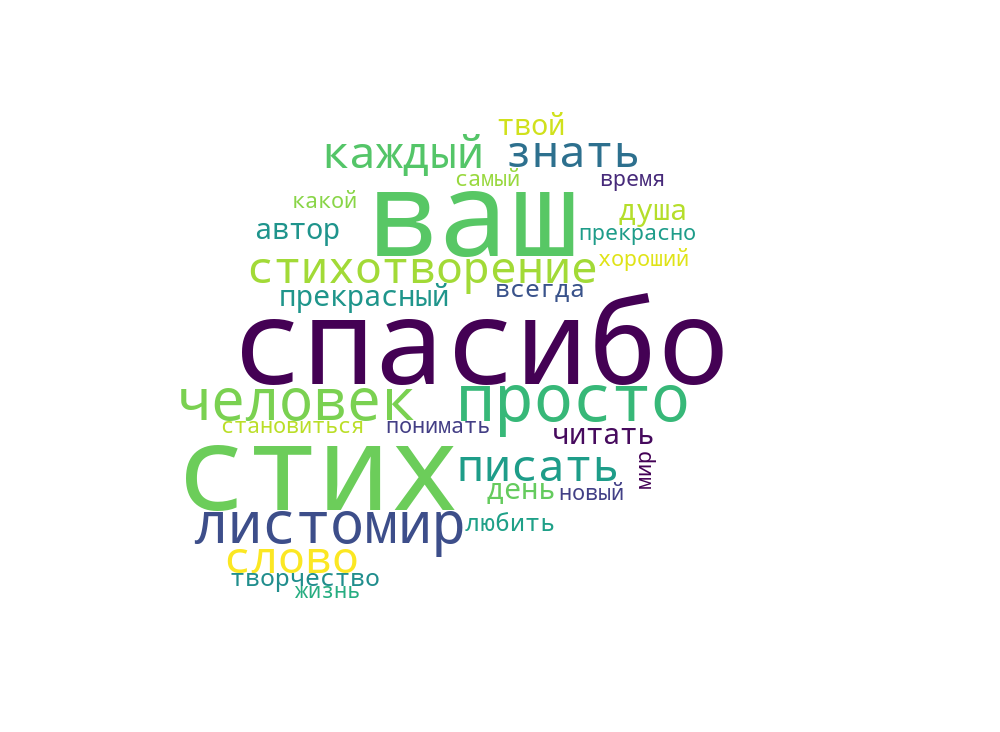

In [25]:
text = ""
for item in lem_freq:
    text += str(item[0]) + " "

comment_mask = np.array(Image.open("listya-47.jpg"))

cloud = WordCloud(background_color="white", max_words=2000, mask=comment_mask)

# генерируем
cloud.generate(text)

# визуализируем
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# store to file
cloud.to_file("word_cloud.png")
Image.open("word_cloud.png")

График зависимости средней длины комментариев от возраста пользователя

In [26]:
x = []
y = []
age = {}
comments = {}
# Собираем все комментарии в словарь по их Id для удобного поиска
for post in posts:
    for comment in post['comments']:
        comments[comment["id"]] = comment

# Для каждого возраста вычисляем среднюю длину комментариев
for id in people:
    if id > 0:
        temp_age = people[id]["age"]
        # Вычисляем среднее для человека
        comments_averege = 0
        for comment_id in people[id]["comments_id"]:
            comments_averege += comments[comment_id]["text_len"]
            comments_averege = round(comments_averege /
                                     len(people[id]["comments_id"]))
        if not age.get(temp_age):
            age[temp_age] = [comments_averege, 1]
        else:
            age[temp_age] = (age[temp_age][0] + comments_averege,
                             age[temp_age][1] + 1)

for key in age:
    age[key] = round(age[key][0]/age[key][1])

for key in age:
    x.append(key)
    y.append(age[key])

data = [go.Bar(x=x, y=y, marker=dict(color='rgb(84,57,100)'))]
layout = go.Layout(
    title=go.layout.Title(
        text='График зависимости средней длины' +
             'комментариев от возраста пользователя ',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Возраст пользователя',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Средняя длина комментариев',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='len_age')

График зависимости средней длины комментария от города пользователя

In [27]:
x = []
y = []
city = {}
comments = {}
for post in posts:
    for comment in post['comments']:
        comments[comment["id"]] = comment

for id in people:
    if id > 0:
        town = None if not people[id]["city"] else people[id]["city"]["title"]
        city[town] = [0, 0]
for comment in comments:
    try:
        if comments[comment]["from_id"] > 0:
            key = (None if not people[comments[comment]["from_id"]]["city"]
                   else people[comments[comment]["from_id"]]["city"]["title"])
            city[key] = [city[key][0] + comments[comment]["text_len"],
                         city[key][1] + 1]
    except:
        print(people[comments[comment]["from_id"]])
for key in city:
    city[key] = round(city[key][0] / city[key][1])


for key in city:
    x.append(key)
    y.append(city[key])

data = [go.Bar(x=x, y=y, marker=dict(color='rgb(156,2,167)'))]
layout = go.Layout(
    title=go.layout.Title(
        text=('График зависимости средней' +
              'длины комментариев от города пользователя'),
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Город пользователя',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Средняя длина комментариев',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='city_len')

График зависимости средней длины поста от месяца публикации

In [28]:
x = []
y = []
months = {}
for post in posts:
    month = time.ctime(post["date"]).split()[1]
    if not months.get(month):
        months[month] = [post["text_len"], 1]
    else:
        months[month] = [months[month][0] + post["text_len"],
                         months[month][1] + 1]

for key in months:
    months[key] = round(months[key][0] / months[key][1])


for key in months:
    x.append(key)
    y.append(months[key])

data = [go.Bar(x=x, y=y, marker=dict(color='rgb(26,22,42)'))]
layout = go.Layout(
    title=go.layout.Title(
        text='График зависимости средней длины поста от месяца публикации',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Месяц публикации',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Средняя длина поста',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='public_month')

График зависимости ср. длины поста от года публикации

In [29]:
x = []
y = []
years = {}
for post in posts:
    year = time.ctime(post["date"]).split()[4]
    if not years.get(year):
        years[year] = [post["text_len"], 1]
    else:
        years[year] = [years[year][0] + post["text_len"],
                       years[year][1] + 1]

for key in years:
    years[key] = round(years[key][0] / years[key][1])


for key in years:
    x.append(key)
    y.append(years[key])

data = [go.Bar(x=x, y=y, marker=dict(color='rgb(0,0,0)'))]
layout = go.Layout(
    title=go.layout.Title(
        text='График зависимости средней длины поста от года публикации',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Год публикации',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Средняя длина поста',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='public_year')